In [2]:
# Import radial_velocity_functions :: Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [3]:
# Import calibration functions :: Run this to reimport without having to restart the whole notebook
import calibration_functions
importlib.reload(calibration_functions)
from calibration_functions import *

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
from tqdm import tqdm
import pandas as pd
from datetime import datetime
from scipy.interpolate import interp1d

plt.rcParams['font.size'] = 16
plt.rc("font", family="serif")

from os import walk

Example: plot orders

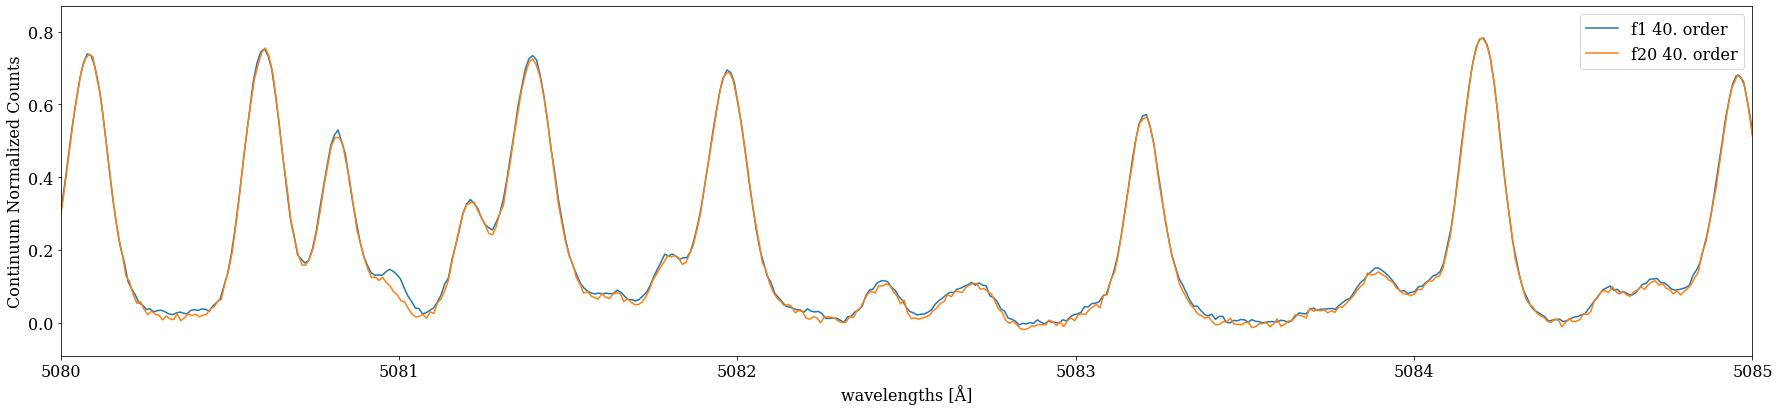

In [25]:
filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_51PEG)
order_data = prepare_orders(filenames[0], angstrom=True, is_peg_51=True)

def plot_order(ax, i, order, x_offset=20):
    d = order_data[order_data.order == order]

    order_data2 = prepare_orders(filenames[i], angstrom=True, is_peg_51=True)
    d2 = order_data2[order_data2.order == order]

    ax.plot(d.x, d.y, label=f"f1 {d.order[0]}. order")
    ax.plot(d2.x, d2.y, label=f"f{i} {d2.order[0]}. order")

    # xmin = min(d.x) + x_offset
    xmin = 5080
    # xmax = xmin + 50
    xmax = 5085

    ax.set_xlim(xmin, xmax)
    # ax.set_xlabel("chromatic-barycentric-corrected Excalibur wavelengths [Å]")
    ax.set_xlabel("wavelengths [Å]")
    ax.set_ylabel("Continuum Normalized Counts")
    ax.legend(loc="upper right")


fig, ax1 = plt.subplots(nrows=1, figsize=(25, 6))
plot_order(ax1, 20, 40, 1)
fig.tight_layout()

IndexError: list index out of range

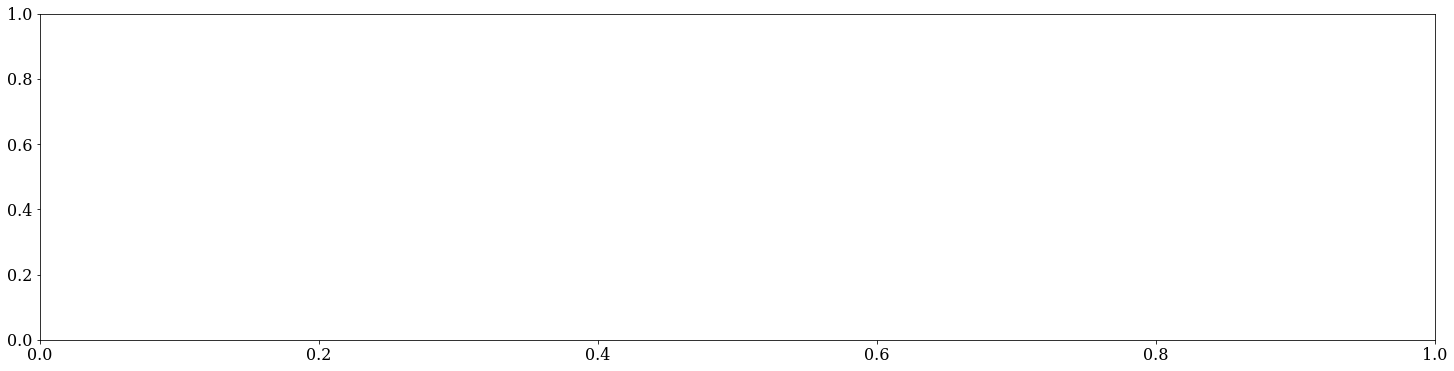

In [15]:
filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_51PEG)[:5]

for k in np.arange(len(filenames)):
    order_data = prepare_orders(filenames[k], angstrom=True, is_peg_51=True)
    fig, ax1 = plt.subplots(nrows=1, figsize=(25, 6))
    plot_order(ax1, 20, 40, 1)
    fig.tight_layout()

Compare first file with all files

In [324]:
# filenames = get_spectra_filenames_without_duplicate_dates()
# order_data = prepare_orders(filenames[0], angstrom=True)

# for i in tqdm(range(len(filenames))):
#     # fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(25, 14))
#     fig, ax1 = plt.subplots(figsize=(25, 6))
#     plot_order(ax1, i, 40, 1)
#     # plot_order(ax2, i, 50, 2)
#     # plot_order(ax3, i, 60, 58)
#     fig.tight_layout()
#     fig.savefig(f"figures/orders_look3/file_{i}.png", dpi=100, facecolor="white")
#     plt.close(fig)

100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Fit order shift



In [27]:
filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_26965)
compute_all_orders_shift(filenames[0], filenames[10], plot_overview=True)

IndexError: string index out of range

### Multi core matrix

In [20]:
import multiprocess

N_files = -1 # for all
# N_files = 20
N_processes = 6

# Get list of files and find all features
filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_51PEG)
if N_files != -1:
    assert N_files > 0, "N_files is negative or zero"
    assert N_files <= len(filenames), "N_files is longer than number of data files"
    filenames = filenames[:N_files]

# Setup coords :: Compute one list of coords
size = len(filenames)
coords = []
for x in np.arange(size):
    for y in np.arange(x, size):
        if x != y:
            coords.append((x, y)) 
        
        
# Define function for each process
def compute_shift_for_coords_chunk(coords):
    x = coords[0]
    y = coords[1]
    shifts = compute_all_orders_shift(filenames[x], filenames[y], is_peg_51=True)
    return shifts


if __name__ == '__main__':
    pool = multiprocess.Pool(processes = N_processes)
    # result = pool.map(compute_shift_for_coords_chunk, coords) # without tqdm

    # With progress bar
    result = []
    print("Computeing shifts for all files combinations...")
    for r in tqdm(pool.imap_unordered(compute_shift_for_coords_chunk, coords), total=len(coords)):
        result.append(r)
        
    print("Finished!")

    np.save("lily_data_results/51_peg_all_orders", [result, coords])

Computeing shifts for all files combinations...


100%|██████████| 276/276 [01:37<00:00,  2.82it/s]

Finished!



/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
# We have these four files: 
# 58x58_orders_34411
# 58x58_orders_26965
# 58x58_orders_10700
# 58x58_orders_101501
# 58x58_orders_34411_non_calib
# 51_peg_all_orders

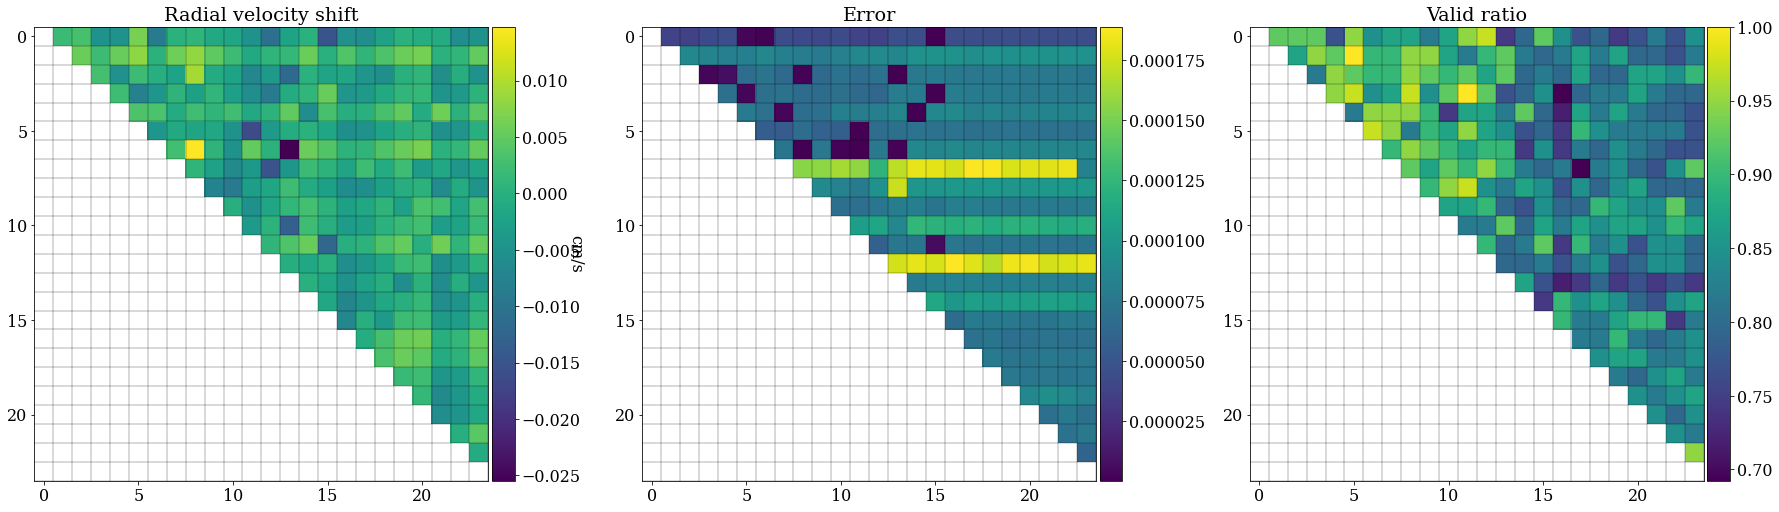

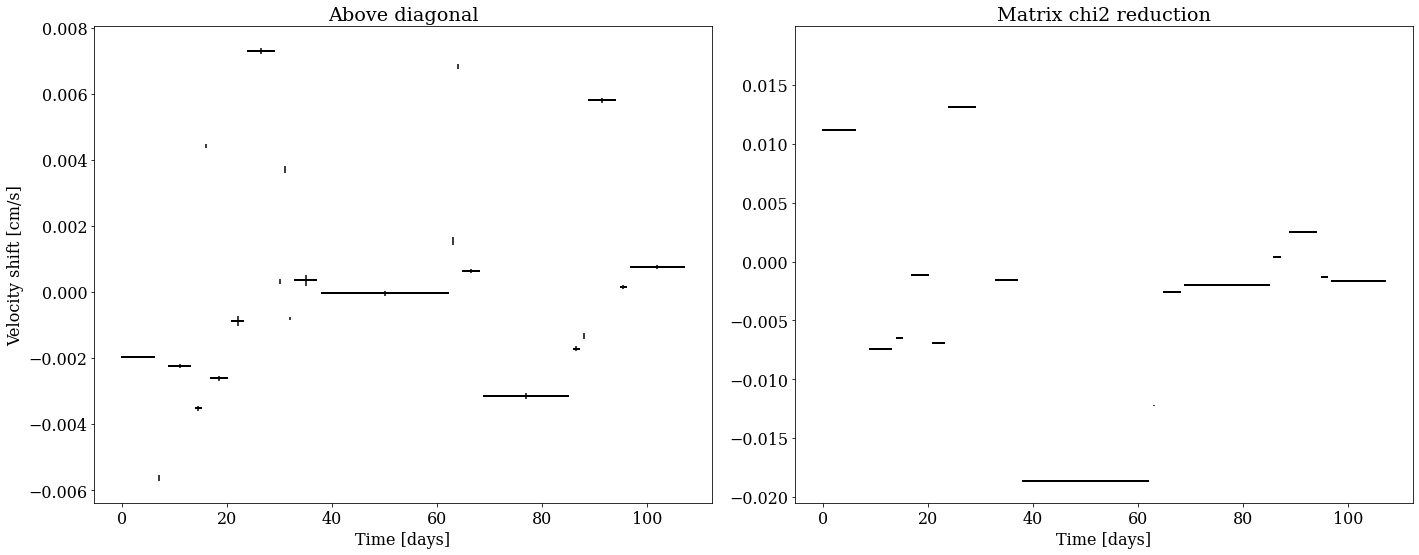

In [21]:
file = "lily_data_results/51_peg_all_orders.npy"
result, coords = np.load(file, allow_pickle=True)
plot_matrix(*parse_matrix_results_df(result, coords))
m, final_shifts, final_shifts_err = matrix_reduce_results_file_df(file, plot=True)

2888 peaks found
2824 peaks found
101 matches found
0 / 101 fits failed


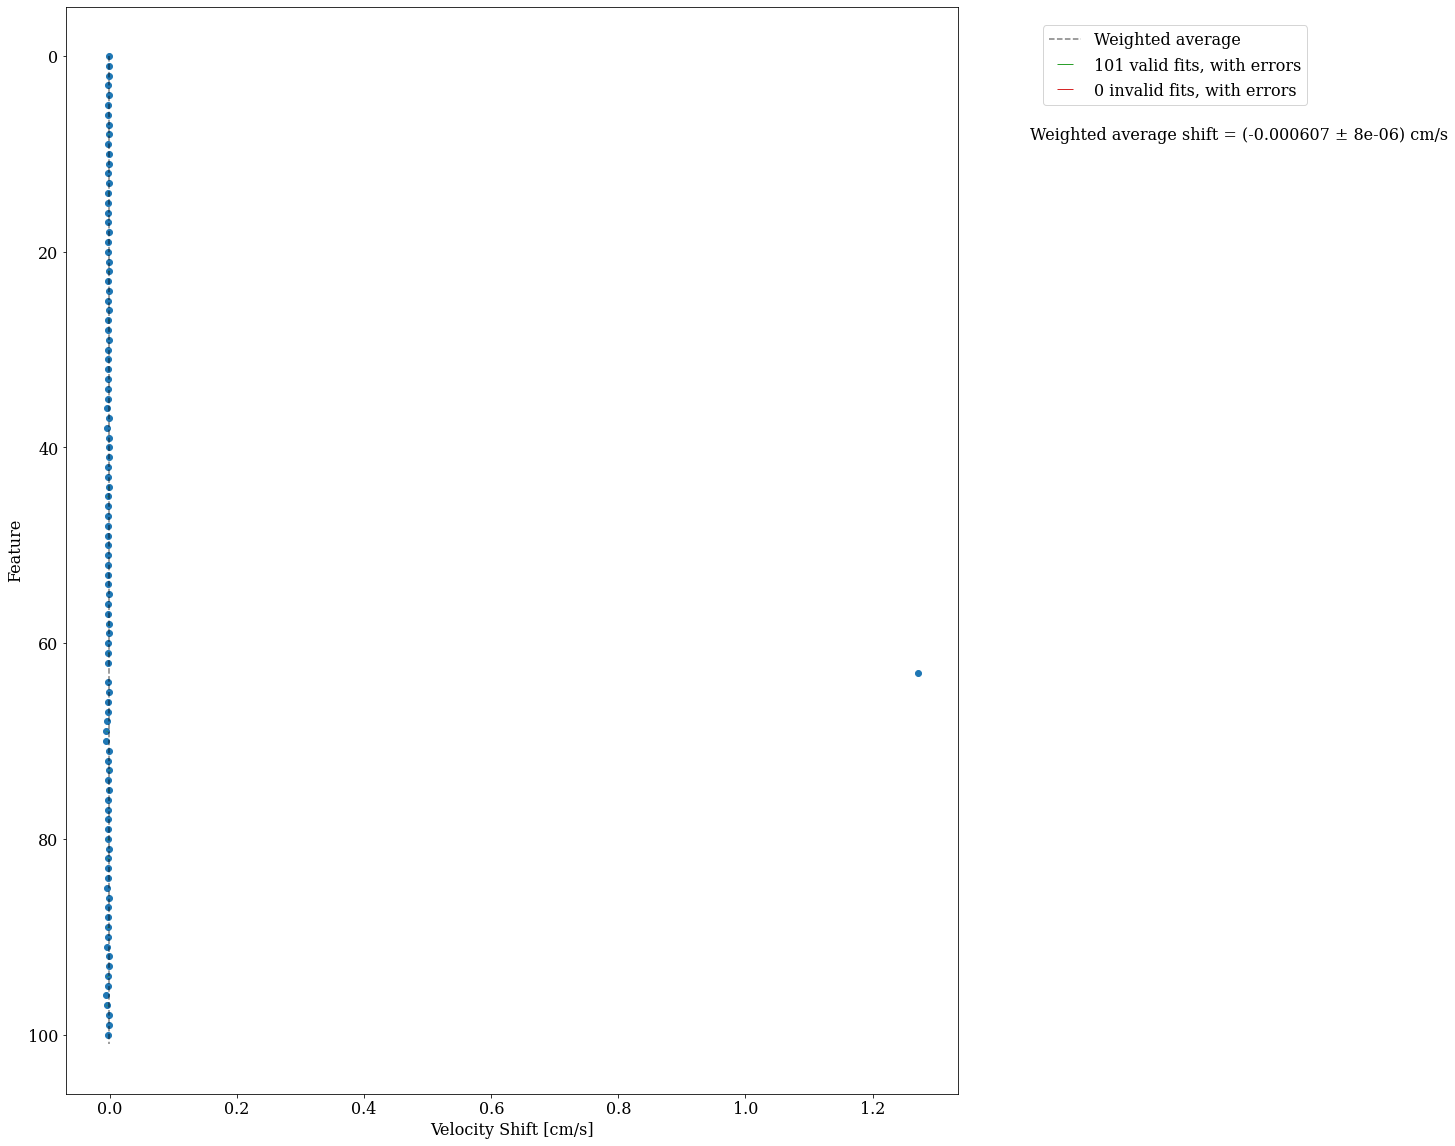

In [29]:

filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_51PEG)
file1, file2 = filenames[1], filenames[8]
matches = find_feature_matches(find_features(file1), find_features(file2))
shifts = compute_all_feature_shifts(matches)
plot_features_shift(shifts)